### Credi Risk Default Modelling

In [8]:
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
train1=pd.read_csv('Final_train1.csv')

In [10]:
test1=pd.read_csv('Final_test1.csv')

In [11]:
TARGET = train1.TARGET # save our TARGET variable
train1.drop('TARGET', axis = 1, inplace = True) # remove TARGET from train1

# allign the datasets
train1, test1 = train1.align(test1, join = 'inner', axis = 1)

In [12]:
print(train1.shape)
print(test1.shape)

(307511, 256)
(48744, 256)


In [13]:
# Define median imputation of missing values
imputer = Imputer(strategy = 'median')

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [14]:
print('Missing values in train data: ', sum(train1.isnull().sum()))
print('Missing values in test data: ', sum(test1.isnull().sum()))

Missing values in train data:  7849912
Missing values in test data:  1117395


In [15]:
# Fit imputer to our train dataset
imputer.fit(train1)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [16]:
# Apply imputer to our dataframes
imputed_train = imputer.transform(train1)
imputed_test = imputer.transform(test1)

# the reason we created new objects (imputed_train/imputed_test) instead of just overriding train/test is because imputer creates 
    # arrays that include all the non missing values and imputed missing values, but it completely discards 
        # features names, which we will need later to examine feature importance

In [17]:
# Fit imputer to our train dataset
imputer.fit(train1)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [18]:
# Apply imputer to our dataframes
imputed_train = imputer.transform(train1)
imputed_test = imputer.transform(test1)

In [19]:
# now before we replace missing values by imputed, let's make sure we understand what will happen
train1.head(5)

,Unnamed: 0,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2,2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
4,4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [20]:
# replace the missing values with imputed ones
train1[train1.isnull()] = imputed_train
test1[test1.isnull()] = imputed_test

In [21]:
sum(train1.isnull().sum())

0

## WOE and IV

In [22]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 10
force_bin = 2

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [23]:
final_iv, IV = data_vars(train1,TARGET)

C:\Users\kunal\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
IV.sort_values('IV',ascending='TRUE')

,VAR_NAME,IV
0,AMT_ANNUITY,0.000000
57,FLOORSMAX_MODE,0.000000
64,LIVINGAREA_AVG,0.000000
65,LIVINGAREA_MEDI,0.000000
66,LIVINGAREA_MODE,0.000000
...,...,...
234,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,0.072352
14,DAYS_BIRTH,0.083843
232,PREV_BUR_MEAN_DAYS_CREDIT,0.089235
24,EXT_SOURCE_3,0.298369


In [25]:
t=IV[IV['IV']>0.03]
p=t.loc[:,'VAR_NAME']
k=t.VAR_NAME
pk=k.to_list()
train3=train1[pk]
train3.shape

(307511, 24)

In [26]:
y = TARGET
X=  train3
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

In [47]:
train3.to_csv("train3.csv")

(307511, 59)

In [48]:
TARGET.to_csv("TARGET.csv")

C:\Users\kunal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
logreg = LogisticRegression(penalty='l1',class_weight='balanced')
t=logreg.fit(X_train, y_train)
Y_log_Pred = logreg.predict(X_test)
logistic_acc = accuracy_score(y_test, Y_log_Pred)
logistic_conf = confusion_matrix(y_test, Y_log_Pred)
print('Logistic accuracy',logistic_acc)
print('Logistic Confusion Matrix',logistic_conf)

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic accuracy 0.682509950831187
Logistic Confusion Matrix [[48365 22307]
 [ 2101  4105]]


C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Classification report

In [115]:
print(metrics.classification_report(y_test,pred_log,digits=2))

              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80     70672
         1.0       0.16      0.66      0.25      6206

   micro avg       0.68      0.68      0.68     76878
   macro avg       0.56      0.67      0.53     76878
weighted avg       0.89      0.68      0.75     76878



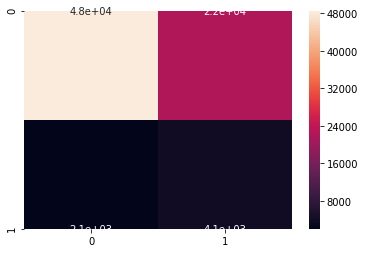

In [68]:
sns.heatmap(logistic_conf, annot=True)

## Accuracy Score

In [116]:
metrics.accuracy_score(y_test,pred_log)

0.682509950831187

In [ ]:
## fpr and tpr

Text(0.5, 0, 'False Positive Rate')

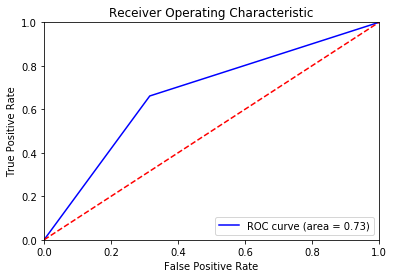

In [119]:
fpr, tpr, threshold = metrics.roc_curve(y_test,Y_log_Pred,drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='ROC curve (area = %0.2f)' % auc_score)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [131]:
cutoff_prob = threshold[(np.abs(tpr - 0.34)).argmin()]
round( float( cutoff_prob ), 2 )

1.0

## AUC

In [134]:
predict_proba = pd.DataFrame(logreg.predict_proba(X_test))
predict_proba.head()

,0,1
0,0.869891,0.130109
1,0.721408,0.278592
2,0.713670,0.286330
3,0.838668,0.161332
4,0.220339,0.779661


In [135]:
pred_log = pd.DataFrame(pred_log)

In [138]:
Y1_test1 = y_test.reset_index()

In [139]:
#then concatenate datasets
predictions = pd.concat([Y1_test1,pred_log,predict_proba],axis = 1)

In [140]:
#the columns of the dataset are renamed and we get the final table that allows us to 
#calculate the AUC score and create ROC Curve

predictions.columns = ['index', 'actual', 'predicted', 'Good_0', 'Bad_1']
predictions.head()

,index,actual,predicted,Good_0,Bad_1
0,107933,0.0,0.0,0.869891,0.130109
1,250993,0.0,0.0,0.721408,0.278592
2,222259,0.0,0.0,0.713670,0.286330
3,26072,0.0,0.0,0.838668,0.161332
4,8173,1.0,1.0,0.220339,0.779661


In [141]:

auc_score = metrics.roc_auc_score( predictions.actual, predictions.Bad_1 )
round( float( auc_score ), 2 )

0.73

## ROC

Text(0.5, 0, 'False Positive Rate')

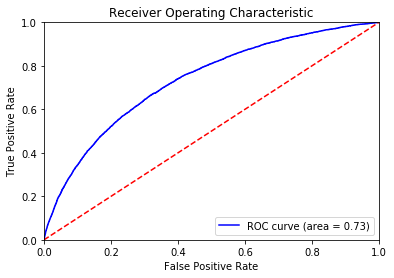

In [142]:
fpr, tpr, threshold = metrics.roc_curve(y_test,predictions.Bad_1,drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='ROC curve (area = %0.2f)' % auc_score)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [149]:
cutoff_prob = threshold[(np.abs(tpr - 0.5)).argmin()]
round( float( cutoff_prob ), 2 )

0.59

In [152]:
#predict the survival rate by using the new cut off value
predictions['new_labels'] = predictions['Bad_1'].map( lambda x: 1 if x >= 0.67 else 0 )
predictions.head()

,index,actual,predicted,Good_0,Bad_1,new_labels
0,107933,0.0,0.0,0.869891,0.130109,0
1,250993,0.0,0.0,0.721408,0.278592,0
2,222259,0.0,0.0,0.713670,0.286330,0
3,26072,0.0,0.0,0.838668,0.161332,0
4,8173,1.0,1.0,0.220339,0.779661,1


Text(0.5, 15.0, 'Predicted label')

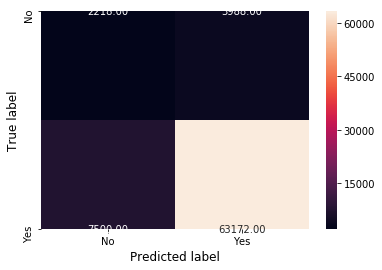

In [153]:
cm1 = metrics.confusion_matrix( predictions.actual,
                          predictions.new_labels, [1,0] )
sn.heatmap(cm1, annot=True,  fmt='.2f', xticklabels = ["No", "Yes"] , yticklabels = ["No", "Yes"],)
plt.ylabel('True label',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)

In [154]:
#New Accuracy

metrics.accuracy_score(predictions.actual,predictions.new_labels, [1,0] )

0.8505684331017976

In [155]:
#classification report
print(metrics.classification_report(predictions.actual,predictions.new_labels,digits=2))

              precision    recall  f1-score   support

         0.0       0.94      0.89      0.92     70672
         1.0       0.23      0.36      0.28      6206

   micro avg       0.85      0.85      0.85     76878
   macro avg       0.58      0.63      0.60     76878
weighted avg       0.88      0.85      0.87     76878



In [74]:
Y_log_Pred = logreg.predict(X_test[pk])

In [75]:
Y_log_Pred = logreg.predict(X_test)

In [76]:
conc =y_test

In [77]:
conc = pd.DataFrame(conc)

In [78]:
pred=logreg.predict_proba(X_test)[:,1]

In [79]:
pred

array([0.13010911, 0.27859168, 0.28633026, ..., 0.20038108, 0.47082097,
       0.47808564])

In [80]:
conc['pred']=pred

In [76]:
#conc.to_csv("conc.csv")

In [81]:

TAR=logreg.predict_proba(test1[pk])[:,1]

In [82]:
test4=test1[pk]

In [83]:
#test4.to_csv("test4.csv")

In [84]:
TAR.shape

(48744,)

In [85]:
d=test1['SK_ID_CURR']
d=pd.DataFrame(d)

In [86]:
d['TARGET']=TAR

In [87]:
predict_proba = pd.DataFrame(logreg.predict_proba(X_test))
predict_proba.head()

,0,1
0,0.869891,0.130109
1,0.721408,0.278592
2,0.713670,0.286330
3,0.838668,0.161332
4,0.220339,0.779661


In [46]:
#d.to_csv('submission.csv')

In [88]:
from sklearn import metrics
auc_score = metrics.roc_auc_score( y_test, Y_log_Pred )
round( float( auc_score ), 2 )

0.67

Text(0.5, 0, 'False Positive Rate')

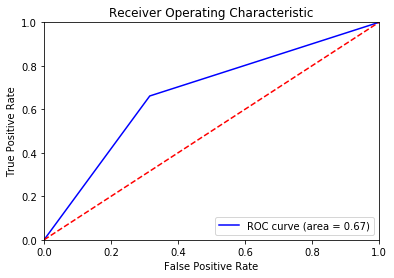

In [89]:
fpr, tpr, threshold = metrics.roc_curve(y_test, Y_log_Pred,drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)
 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='ROC curve (area = %0.2f)' % auc_score)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [90]:
accuracy_score(y_test, Y_log_Pred)

0.682509950831187

In [91]:
#Python
predict_proba = pd.DataFrame(logreg.predict_proba(X_test))
predict_proba.head()

,0,1
0,0.869891,0.130109
1,0.721408,0.278592
2,0.713670,0.286330
3,0.838668,0.161332
4,0.220339,0.779661


In [92]:
pred_log = pd.DataFrame(Y_log_Pred)

In [93]:
Y1_test1 = y_test.reset_index()

In [94]:
predictions = pd.concat([Y1_test1,pred_log,predict_proba],axis = 1)
predictions.head()

,index,TARGET,0,0,1
0,107933,0.0,0.0,0.869891,0.130109
1,250993,0.0,0.0,0.721408,0.278592
2,222259,0.0,0.0,0.713670,0.286330
3,26072,0.0,0.0,0.838668,0.161332
4,8173,1.0,1.0,0.220339,0.779661


In [95]:
predictions.columns = ['index', 'actual', 'predicted', 'good_0', 'bad_1']
predictions.head()

,index,actual,predicted,good_0,bad_1
0,107933,0.0,0.0,0.869891,0.130109
1,250993,0.0,0.0,0.721408,0.278592
2,222259,0.0,0.0,0.713670,0.286330
3,26072,0.0,0.0,0.838668,0.161332
4,8173,1.0,1.0,0.220339,0.779661


In [96]:
from sklearn import metrics
cutoff_prob = threshold[(np.abs(tpr - 0.60)).argmin()]
round( float( cutoff_prob ), 2 )

1.0

In [97]:
predictions['new_labels'] = predictions['bad_1'].map( lambda x: 1 if x >= 0.6 else 0 )
predictions.head()

,index,actual,predicted,good_0,bad_1,new_labels
0,107933,0.0,0.0,0.869891,0.130109,0
1,250993,0.0,0.0,0.721408,0.278592,0
2,222259,0.0,0.0,0.713670,0.286330,0
3,26072,0.0,0.0,0.838668,0.161332,0
4,8173,1.0,1.0,0.220339,0.779661,1


In [98]:
metrics.accuracy_score(predictions.actual,predictions.new_labels, [1,0] )

0.795741304404381

Text(0.5, 15.0, 'Predicted label')

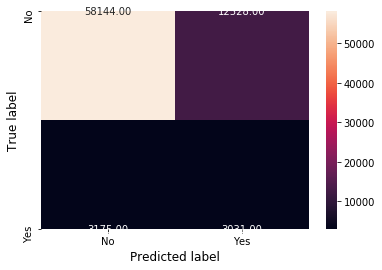

In [99]:
import seaborn as sn
ax= plt.subplot()
cm1 = metrics.confusion_matrix( predictions.actual,
                          predictions.new_labels )
sn.heatmap(cm1, annot=True,  fmt='.2f', xticklabels = ["No", "Yes"] , yticklabels = ["No", "Yes"],ax=ax)
plt.ylabel('True label',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)

In [100]:
print(classification_report(y_test, Y_log_Pred,digits=2))

              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80     70672
         1.0       0.16      0.66      0.25      6206

   micro avg       0.68      0.68      0.68     76878
   macro avg       0.56      0.67      0.53     76878
weighted avg       0.89      0.68      0.75     76878



Text(0.5, 0, 'False Positive Rate')

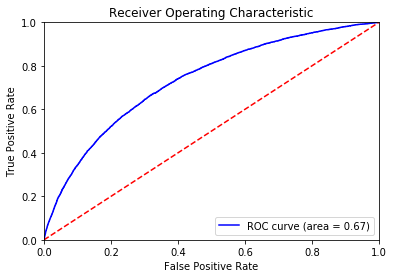

In [101]:
fpr, tpr, threshold = metrics.roc_curve(y_test,predictions.bad_1,drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)
 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='ROC curve (area = %0.2f)' % auc_score)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [102]:
y_proba=logreg.predict_proba(test1[pk])[:,1]

In [103]:

from sklearn import metrics
auc_score = metrics.roc_auc_score( predictions.actual, predictions.bad_1 )
round( float( auc_score ), 2 )


0.73

In [104]:
conc.pred

107933    0.130109
250993    0.278592
222259    0.286330
26072     0.161332
8173      0.779661
            ...   
280145    0.628874
303957    0.573537
244702    0.200381
139747    0.470821
98648     0.478086
Name: pred, Length: 76878, dtype: float64

In [105]:
results = pd.DataFrame({'y': y_train, 'y_proba': conc.pred})
results = results.sort_values(by='y_proba', ascending=True).reset_index(drop=True)
results.index = results.index + 1
results.index = results.index / len(results.index) * 100

In [111]:

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions.bad_1)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
print(roc_auc())

0.7328674032724909


TypeError: 'numpy.float64' object is not callable

C:\Users\kunal\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\kunal\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\kunal\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\kunal\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\kunal\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\kunal\Anaconda3\lib\site-pa

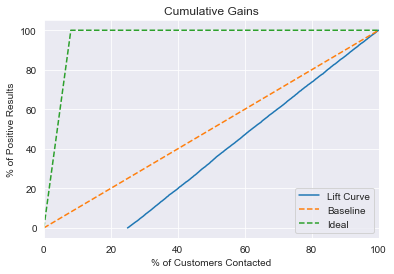

In [129]:
sns.set_style('darkgrid')
pred = results
pred['Lift Curve'] = pred.y.cumsum() / pred.y.sum() * 100
pred['Baseline'] = pred.index
base_rate = y.sum() / len(y) * 100
pred[['Lift Curve', 'Baseline']].plot(style=['-', '--', '--'])
pd.Series(data=[0, 100, 100], index=[0, base_rate, 100]).plot(style='--')
plt.title('Cumulative Gains')
plt.xlabel('% of Customers Contacted')
plt.ylabel("% of Positive Results")
plt.legend(['Lift Curve', 'Baseline', 'Ideal']);

In [ ]:
model.fit(train[pk],data[outcome])

In [ ]:
# Cross Validation

In [ ]:
y = TARGET
X=  train1
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

In [ ]:
#Model Fitting

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
logreg = LogisticRegression(penalty="l1",class_weight='balanced')
logreg.fit(X_train, y_train)
Y_log_Pred = logreg.predict(X_test)
logistic_acc = accuracy_score(y_test, Y_log_Pred)
logistic_conf = confusion_matrix(y_test, Y_log_Pred)
print('Logistic accuracy',logistic_acc)
print('Logistic Confusion Matrix',logistic_conf)

C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\kunal\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Logistic accuracy 0.6902364785764458
Logistic Confusion Matrix [[48934 21738]
 [ 2076  4130]]


In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_test,predictions.bad_1,drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)
 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='ROC curve (area = %0.2f)' % auc_score)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
sum(train1.isnull().sum()) # we've gotten rid of all our NAs

In [ ]:
#Cross Validation
TARGET.shape,train1.shape

In [ ]:
y = TARGET
X=  train1
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.30)